In [1]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import scienceplots
import latex
import random

from sklearn.metrics import accuracy_score
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Set plotting parameters
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')

# Read data
df_og = load(config['PATH']['DATA_DIR'] + '/full_df_daily_cap95.joblib')

c:\Users\caspa\OneDrive - Vrije Universiteit Amsterdam\VU Master\data-mining-techniques-vu\windows\data-mining-techniques-vu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'text' from partially initialized module 'keras.api._v2.keras.preprocessing' (most likely due to a circular import) (c:\Users\caspa\OneDrive - Vrije Universiteit Amsterdam\VU Master\data-mining-techniques-vu\windows\data-mining-techniques-vu\.venv\Lib\site-packages\keras\api\_v2\keras\preprocessing\__init__.py)

In [12]:
# Construct target as bad (0-6), okay (6-8), good (8-10)
df = df_og.copy()
# df = df.drop(columns = ['time'])
df['target'] = df['target'].apply(lambda x: 0 if x < 7 else 1)

# Impute outliers (larger than 1.5 IQR) with mean of column in all _sum columns
# for col in df.columns:
#     if col.endswith('_sum'):
#         df[col] = df[col].mask(df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)), df[col].mean())

In [13]:
X, y = df.drop(columns=['target'], axis = 1), df['target']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_ts(X, y, split_ratios=[0.5, 0.2])

# Full train set for final model
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Get non-dummy columns
if len([var for var in df.columns if var.startswith('day')]) == 7:
    df = df.drop(columns=['day_of_week_0'])
dummy_cols = [var for var in df.columns if var.startswith('day')] + ['target', 'activity_idc', 'call_idc', 'sms_idc', 'id']
cols_no_dummy = [var for var in X_train.columns if var not in dummy_cols]

# Scale data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([('scaler', StandardScaler(), cols_no_dummy)], remainder='passthrough')
ct.set_output(transform='pandas')
X_train_scaled = ct.fit_transform(X_train)
X_val_scaled = ct.transform(X_val)


In [14]:
def shape_lstm(X, y, seq_length):
    import numpy as np

    X_lstm = []
    y_lstm = []
    
    # Iterate over persons:
    for person in X['remainder__id'].unique():
        # Get all days for this person
        X_person = X[X['remainder__id'] == person].drop(columns = ['remainder__id']).values
        y_person = y[X['remainder__id'] == person].drop(columns = ['remainder__id']).values

        i = 0
        while i < len(X_person):
            # If days are less than seq_length, pad with zeros at the beginning of X
            if len(X_person) < seq_length:
                n_missing = seq_length - len(X_person)
                X_padded = np.pad(X_person, ((n_missing, 0), (0, 0)), mode='constant', constant_values=0)
                X_lstm.append(X_padded)
                y_lstm.append(y_person[-1])
                break

            # If days are more than seq_length, create sequences of seq_length days
            elif i + seq_length <= len(X_person):
                X_lstm.append(X_person[i:i+seq_length])
                y_lstm.append(y_person[i+seq_length-1])
                i += 1

            # If the remaining days are not enough to form a full sequence, stop iterating
            else:
                break
                
        # Add sequenced data for this person to the list of all sequences

    # Convert lists to numpy arrays and reshape y_lstm
    X_lstm = np.array(X_lstm).astype('float32'	)
    y_lstm = np.array(y_lstm).reshape(-1, 1).astype('float32')

    # Return full sequenced dataframe
    return X_lstm, y_lstm


# Define the LSTM model
def build_lstm_model(input_shape, hunits = 128):
    model = Sequential()
    model.add(LSTM(hunits, input_shape=input_shape, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    return model



In [15]:
seq_length = 7
X_lstm_train, y_lstm_train = shape_lstm(X_train_scaled, y_train, seq_length=seq_length)
X_lstm_val, y_lstm_val = shape_lstm(X_val_scaled, y_val, seq_length=seq_length)


In [1]:
# Define the objective function for the optimization
def objective(trial: Trial):
    hidden_units = trial.suggest_int('hunits', 16, 256, step=16)
    epochs = trial.suggest_int('epochs', 5, 40, step=5)


    input_shape = (seq_length, X_lstm_train.shape[2])
    model = build_lstm_model(input_shape, hidden_units)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_lstm_train, y_lstm_train, epochs=epochs, verbose=0)
    score = model.evaluate(X_lstm_val, y_lstm_val, verbose=0)

    return score[1]

# Optimize the pipeline using Optuna
manual_seed = 42
np.random.seed(manual_seed)
random.seed(manual_seed)
tf.random.set_seed(manual_seed)
sampler = TPESampler(seed=manual_seed)

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Print the best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.number}, Accuracy: {best_trial.value}")
print(f"Best params: {best_trial.params}")


NameError: name 'Trial' is not defined

Model: "sequential_250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_249 (LSTM)             (None, 32)                10240     
                                                                 
 dense_249 (Dense)           (None, 1)                 33        
                                                                 
Total params: 10,273
Trainable params: 10,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
21/21 [==============================] - 3s 4ms/step - loss: 0.6361 - accuracy: 0.6403
Epoch 2/15
21/21 [==============================] - 0s 4ms/step - loss: 0.5690 - accuracy: 0.7411
Epoch 3/15
21/21 [==============================] - 0s 5ms/step - loss: 0.5320 - accuracy: 0.7457
Epoch 4/15
21/21 [==============================] - 0s 4ms/step - loss: 0.5139 - accuracy: 0.7488
Epoch 5/15
21/21 [==============================] - 

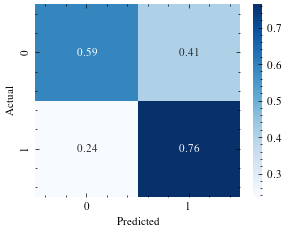

In [33]:
# Train the model on the full training set
ct = ColumnTransformer([('scaler', StandardScaler(), cols_no_dummy)], remainder='passthrough')
ct.set_output(transform='pandas')

X_train_full_scaled = ct.fit_transform(X_train_full)
X_test_scaled = ct.transform(X_test)

X_train_full_lstm, y_train_full_lstm = shape_lstm(X_train_full_scaled, y_train_full, seq_length=7)
X_test_lstm, y_test_lstm = shape_lstm(X_test_scaled, y_test, seq_length=7)

# Set the input_shape for your model based on your input data
input_shape = (seq_length, X_train_full_lstm.shape[2])
model2 = build_lstm_model(input_shape, hunits=best_trial.params['hunits'])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()
hist_full = model2.fit(X_train_full_lstm, y_train_full_lstm, epochs=best_trial.params['epochs'], batch_size=32)


# Predict on the test set
y_pred = model2.predict(X_test_lstm)

# Evaluate the model
score = model2.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.round(y_pred)
cm = confusion_matrix(y_test_lstm, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('figures/lstm_confusion_matrix.pdf')
plt.show()


In [186]:
# dataframe with x = 1,2,3,4
df = pd.DataFrame({'x': [1,2,3,4]})
df.shift(-1)

,x
0,2.0
1,3.0
2,4.0
3,NaN


In [31]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_lstm, y_pred.flatten()))


              precision    recall  f1-score   support

         0.0       0.68      0.56      0.62       108
         1.0       0.68      0.77      0.72       127

    accuracy                           0.68       235
   macro avg       0.68      0.67      0.67       235
weighted avg       0.68      0.68      0.67       235



In [29]:
y_pred.flatten()

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0.